<a href="https://colab.research.google.com/github/IMOKURI/signate-471/blob/main/%E5%8C%BB%E5%AD%A6%E8%AB%96%E6%96%87%E3%81%AE%E8%87%AA%E5%8B%95%E4%BB%95%E5%88%86%E3%81%91%E3%83%81%E3%83%A3%E3%83%AC%E3%83%B3%E3%82%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About this notebook ...

competition site: https://signate.jp/competitions/471







## ToDo

- [ ] pre train のモデルの save と load
- [ ] preprocess したデータの save と load (wandb)

### Idea

- [ ] 分類で推論、回帰で推論
- [x] 回帰の場合の境界値の最適化
    - [ ] second stage で学習べきかも
        - [ ] heamy という stacking のライブラリがある
    - [ ] Nelder-Mead 法 という最適化手法を調べる
- [ ] 最適な境界値はモデルによって異なるので、アンサンブルの時は、 vote ensemble がいいかもしれない
- [x] アブストで事前学習して、タイトルでメイン学習 https://www.kaggle.com/maunish/clrp-pytorch-roberta-pretrain
    - 事前学習は、Masked LM
- [x] タイトルだけで学習・推論
- [ ] タイトル + アブストで学習・推論
    - [ ] タイトルだけで推論したのとアンサンブルができる
    - [ ] Longformer がいいかもしれない `allenai/longformer-base-4096`
    - [ ] large モデルためす
- [ ] アブスト + タイトル で学習・推論
- [ ] アブストが空 or not でモデルわける
- [ ] アブストの max length 調整
    - [ ] 途中で切る。デフォルトの 512 はありそう。ほとんどのアブストがその長さで収まる
    - [ ] 要約する方法があるかなぁ
- [x] dropout を 0 にする
- [x] gradient cripping を 0.2 or 0.5 で試す
- [ ] re-initialization
    - This paper (https://arxiv.org/pdf/2006.05987.pdf) shows that fine-tuning with reinitialization last N layers works well.
    - Different models have different optimal N. Almost models set N=4~5, gpt2-models set N=6.
    - https://github.com/kurupical/commonlit/blob/8781139c8ed4cc59f7c7ac9d97c72c351ee91377/exp/exp502.py#L497
- [ ] Pre trained なレイヤーのfreeze https://raphaelb.org/posts/freezing-bert/
- [ ] Recall を伸ばすための loss function は考えられるか。 https://openreview.net/pdf?id=SlprFTIQP3
    - [x] f1 score を微分可能にして、 loss 関数に使うアプローチ https://gist.github.com/SuperShinyEyes/dcc68a08ff8b615442e3bc6a9b55a354 https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d
    - [ ] epoch ごとに beta の値を増やしていく epoch * 2 とか
- [ ] 出現する単語のクラスタリング
- [x] TF-IDF して、 リッジ回帰 → ベースライン2 でやった
    - IF-IDF の結果もBERTの特徴量にできないだろうか
    - https://www.kaggle.com/semyonkoshkarov/tf-idf-linearsvr-baseline も参考になるかも
- [ ] 医療用語で事前学習されたモデルを使ってみる
    - [x] BioBERT https://github.com/dmis-lab/biobert `dmis-lab/biobert-base-cased-v1.1` 286k downloads
        - [ ] large モデル試す
    - [ ] Med-BERT https://github.com/ZhiGroup/Med-BERT
        - 診断精度に貢献しているかもしれない(いや、一般的な話だったｗ) https://www.nature.com/articles/s41746-021-00455-y
    - [x] `microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext` 30.8k downloads https://www.axion.zone/microsoft-researchers-claim-state-of-the-art-biomedical-nlp-model/
    - [x] `bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12` 4.3k downloads https://github.com/ncbi-nlp/bluebert
        - [ ] large モデル試す
    - [x] `emilyalsentzer/Bio_ClinicalBERT` https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT
    - [ ] `emilyalsentzer/Bio_Discharge_Summary_BERT` https://huggingface.co/emilyalsentzer/Bio_Discharge_Summary_BERT
    - [x] `lordtt13/COVID-SciBERT` https://huggingface.co/lordtt13/COVID-SciBERT
    - [ ] `allenai/scibert_scivocab_uncased` https://huggingface.co/allenai/scibert_scivocab_uncased
- [ ] Augmentation https://neptune.ai/blog/data-augmentation-nlp
    - [ ] Back translation: 他言語に翻訳して、もう一回翻訳する（英語→フランス語→英語） https://qiita.com/nena0undefined/items/c2926bad07039e5540ab
    - [ ] Synonym Replacement: 単語のいくつかを、同じ意味の別の単語に置き換える
        - [ ] 自然言語の augmentation ができるライブラリ https://github.com/makcedward/nlpaug
- [ ] TTA
- [ ] ベースラインのシンプルさを取り戻す。(思ったよりベースラインのスコアが良かったので、それを取り込む・・・）
    - [ ] weight decay を調整 0.01 or 0


### Experiments

- BERT でアブストの　pre train をしてもスコアは上がっていない（学習の方法を工夫した方がよいかも）
- BERT Large は title の学習には大きすぎて？ loss が Base モデルに及ばない。
- epoch 3 で val loss が下がらないので、 epoch 3 で aug かけるとかありかもしれない
- `dmis-lab/biobert-base-cased-v1.1` と `bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12` の成績がよい


## Prepare for Colab

In [1]:
!nvidia-smi

Sat Aug  7 04:16:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    53W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import sys

if os.path.exists('init.txt'):
    print("Already initialized.")

else:
    if 'google.colab' in sys.modules:
        from google.colab import drive
        drive.mount('/gdrive')

        !cp /gdrive/MyDrive/Datasets/signate-471/train.csv .
        !cp /gdrive/MyDrive/Datasets/signate-471/test.csv .
        !cp /gdrive/MyDrive/Datasets/signate-471/sample_submit.csv .

    # for StratifiedGroupKFold
    # !pip uninstall -y scikit-learn
    # !pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn

    # for MultilabelStratifiedKFold
    !pip install -q iterative-stratification

    # !pip install -qU 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup'

    !pip install -q wandb
    !pip install -q transformers
    !pip install -q textstat

    !touch init.txt

Already initialized.


## Library

In [3]:
import glob
import json
import math
import os
import random
import re
import time
import warnings
from contextlib import contextmanager

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import textstat
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers as T
import wandb
# from cosine_annealing_warmup import CosineAnnealingWarmupRestarts
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error, fbeta_score
from sklearn.model_selection import KFold, StratifiedKFold  # , StratifiedGroupKFold
from torch.optim import SGD, Adam  # , AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm


In [4]:
warnings.filterwarnings("ignore")

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
netrc = "../input/wandbtoken/.netrc"

if 'google.colab' in sys.modules:
    netrc = "/gdrive/MyDrive/.netrc"

!cp -f {netrc} ~/

!wandb login

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [8]:
wandb_job_type = ""
wandb_notes = ""
wandb_tags = []

## Load Data

In [9]:
DATA_DIR = "../input/signate-471/"
OUTPUT_DIR = "./"

if 'google.colab' in sys.modules:
    DATA_DIR = "./"

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [10]:
train = pd.read_csv(DATA_DIR + "train.csv")
test = pd.read_csv(DATA_DIR + "test.csv")
sub = pd.read_csv(DATA_DIR + "sample_submit.csv", header=None)
sub.columns = ["id", "judgement"]

## Config

In [11]:
class Config:
    wandb_entity = "imokuri"
    wandb_project = "signate-471"
    print_freq = 100

    pre_train = False
    train = True
    validate = False
    inference = False

    debug = False
    multi_gpu = False
    apex = False


In [12]:
if Config.pre_train:
    wandb_job_type = "pre_training"

elif Config.train:
    wandb_job_type = "training"

elif Config.inference:
    wandb_job_type = "inference"

elif Config.validate:
    wandb_job_type = "validation"

In [13]:
if Config.apex:
    from apex import amp

In [14]:
# seed = random.randrange(10000)
seed = 440

print(seed)

440


In [15]:
config_defaults = {
    "seed": seed,
    "input": "abstract_title",  # "preprocessed_title_abstract",  # "title", # "title_abstract",
    "max_len": 512,
    "border": "minimize", # "fixed", "minimize",
    "n_class": 1,
    "n_fold": 5,
    "gradient_accumulation_steps": 2,
    "max_grad_norm": 1000,
    "num_workers": 4,
    "batch_size": 12,
    "epochs": 3,
    "optimizer": "BertAdamW",
    "scheduler": "get_cosine_schedule_with_warmup",
    "criterion": "BCEWithLogitsLoss",  # "FBetaLoss",  # "BCEWithLogitsLoss",
    "lr": 2e-5,
    "min_lr": 1e-5,
    "weight_decay": 0.01,
    "dropout": 0.1,
    "model_name": "dmis-lab/biobert-base-cased-v1.1-squad",
    # "bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12",
    # "bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12",
    # "bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16",
    # "bionlp/bluebert_pubmed_mimic_uncased_L-24_H-1024_A-16",
    # "dmis-lab/biobert-base-cased-v1.1",
    # "dmis-lab/biobert-base-cased-v1.1-squad",
    # "dmis-lab/biobert-large-cased-v1.1",
    # "dmis-lab/biobert-large-cased-v1.1-squad",
    "reinit_layers": 0,
    "freeze_layers": 0,
    "inference_runs": [
        "1kxyqvm2",  # 53
    ],
}


In [16]:
if not Config.validate and not Config.inference:
    config_defaults["inference_runs"] = []

In [17]:
if Config.debug:
    config_defaults["epochs"] = 1
    Config.print_freq = 10

In [18]:
if config_defaults["optimizer"] == "BertAdamW":
    config_defaults["lr_69"] = 5e-5
    config_defaults["lr_133"] = 1e-4


In [19]:
# Update by epoch
# num_steps = config_defaults["epochs"]

# Update by batch
num_data = 1000 if Config.debug else len(train)
num_steps = num_data // config_defaults["n_fold"] * (config_defaults["n_fold"] - 1) // config_defaults["batch_size"] // config_defaults["gradient_accumulation_steps"] * config_defaults["epochs"]

print(num_steps)

if config_defaults["scheduler"] == "CosineAnnealingWarmRestarts":
    config_defaults["T_0"] = num_steps

elif config_defaults["scheduler"] == "CosineAnnealingLR":
    config_defaults["T_max"] = num_steps

elif config_defaults["scheduler"] == "ReduceLROnPlateau":
    config_defaults["factor"] = 0.2
    config_defaults["patience"] = 4
    config_defaults["eps"] = 1e-6

elif config_defaults["scheduler"] == "CosineAnnealingWarmupRestarts":
    config_defaults["first_cycle_steps"] = num_steps
    config_defaults["warmup_steps"] = num_steps // 10

elif config_defaults["scheduler"] == "get_cosine_schedule_with_warmup":
    config_defaults["num_training_steps"] = num_steps
    config_defaults["num_warmup_steps"] = max(50, num_steps // 10)

2712


In [20]:
if Config.debug:
    run = wandb.init(project=Config.wandb_project, config=config_defaults, mode="disabled")
else:
    run = wandb.init(project=Config.wandb_project, config=config_defaults, notes=wandb_notes, tags=wandb_tags, job_type=wandb_job_type, save_code=True)

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [21]:
config = wandb.config

## EDA-1

In [22]:
# アブストが空っぽのが結構ある
print(train.isnull().sum())
print(test.isnull().sum())

id              0
title           0
abstract     4390
judgement       0
dtype: int64
id             0
title          0
abstract    6546
dtype: int64


## Preprocessing

In [23]:
def preprocess(data):
    
    title_abstract = []
    for e in data:

        # アルファベット以外は空白に置換します。
        e = re.sub("[^a-zA-Z]", " ", e)

        # 小文字に変換します。
        e = e.lower()

        # token に分割します。
        e = nltk.word_tokenize(e)

        # stop word を削除します。
        e = [word for word in e if not word in set(nltk.corpus.stopwords.words("english"))]

        # 見出し語化します。
        lemma = nltk.WordNetLemmatizer()
        e = [lemma.lemmatize(word) for word in e]
        e = " ".join(e)

        title_abstract.append(e)

    return title_abstract

In [24]:
def get_train_data(train):

    # NaN を空白で埋めます。
    train = train.fillna("")

    # abstract の有無を Stratified KFold で使います。
    train["nan_abstract"] = np.where(train["abstract"] == "", 1, 0)

    # title の単語数
    train["len_title"] = train["title"].apply(lambda x: len(x.split()))

    # abstract の単語数
    train["len_abstract"] = train["abstract"].apply(lambda x: len(x.split()))

    # title と abstract を接続します。
    train["title_abstract"] = train[["title", "abstract"]].agg(" ".join, axis=1)
    train["abstract_title"] = train[["abstract", "title"]].agg(" ".join, axis=1)

    # train["preprocessed_title_abstract"] = preprocess(train["title_abstract"])

    # 前処理した文の単語数
    # train["len_preprocessed_title_abstract"] = train["preprocessed_title_abstract"].apply(lambda x: len(x.split()))

    return train

In [25]:
def get_test_data(test):

    # NaN を空白で埋めます。
    test = test.fillna("")

    # title の単語数
    test["len_title"] = test["title"].apply(lambda x: len(x.split()))

    # abstract の単語数
    test["len_abstract"] = test["abstract"].apply(lambda x: len(x.split()))

    # title と abstract を接続します。
    test["title_abstract"] = test[["title", "abstract"]].agg(" ".join, axis=1)
    test["abstract_title"] = test[["abstract", "title"]].agg(" ".join, axis=1)

    # test["preprocessed_title_abstract"] = preprocess(test["title_abstract"])

    # 前処理した文の単語数
    # test["len_preprocessed_title_abstract"] = test["preprocessed_title_abstract"].apply(lambda x: len(x.split()))

    return test

In [26]:
if False:  # os.path.exists("/gdrive/MyDrive/Datasets/signate-471/preprocessed_train.csv"):
    !cp -f /gdrive/MyDrive/Datasets/signate-471/preprocessed_train.csv .
    train = pd.read_csv("preprocessed_train.csv")

    # csv を再読み込みすると NaN に戻ってしまうので、再度変換します。
    train = train.fillna("")

else:
    # 一度、前処理したものは保存しておきます。
    train = get_train_data(train)
    # train.to_csv("preprocessed_train.csv")

    # artifact = wandb.Artifact('preprocessed_train', type='dataset')
    # artifact.add_file("preprocessed_train.csv")
    # run.log_artifact(artifact)

    # !cp -f preprocessed_train.csv /gdrive/MyDrive/Datasets/signate-471/

In [27]:
if False:  # os.path.exists("/gdrive/MyDrive/Datasets/signate-471/preprocessed_test.csv"):
    !cp -f /gdrive/MyDrive/Datasets/signate-471/preprocessed_test.csv .
    test = pd.read_csv("preprocessed_test.csv")

    # csv を再読み込みすると NaN に戻ってしまうので、再度変換します。
    test = test.fillna("")

else:
    # 一度、前処理したものは保存しておきます。
    test = get_test_data(test)
    # test.to_csv("preprocessed_test.csv")

    # artifact = wandb.Artifact('preprocessed_test', type='dataset')
    # artifact.add_file("preprocessed_test.csv")
    # run.log_artifact(artifact)

    # !cp -f preprocessed_test.csv /gdrive/MyDrive/Datasets/signate-471/

## EDA-2

In [28]:
# abstract に改行は含まれていない
print(len(train[train["abstract"].str.contains("\n")]))
print(len(test[test["abstract"].str.contains("\n")]))

0
0


In [29]:
# title の単語数
print(train["len_title"].max())
print(test["len_title"].max())

53
69


In [30]:
# abstract の単語数
print(train["len_abstract"].max())
print(test["len_abstract"].max())

1535
1445


In [31]:
# 前処理した文の単語数
# print(train["len_preprocessed_title_abstract"].max())
# print(test["len_preprocessed_title_abstract"].max())

In [32]:
for ds in [train, test, sub]:
    print(f"=" * 80)
    ds.info()
    display(ds.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27145 entries, 0 to 27144
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              27145 non-null  int64 
 1   title           27145 non-null  object
 2   abstract        27145 non-null  object
 3   judgement       27145 non-null  int64 
 4   nan_abstract    27145 non-null  int64 
 5   len_title       27145 non-null  int64 
 6   len_abstract    27145 non-null  int64 
 7   title_abstract  27145 non-null  object
 8   abstract_title  27145 non-null  object
dtypes: int64(5), object(4)
memory usage: 1.9+ MB


,id,title,abstract,judgement,nan_abstract,len_title,len_abstract,title_abstract,abstract_title
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,0,10,193,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,0,23,214,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,0,10,133,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,0,13,374,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,,0,1,16,0,Prolonged shedding of SARS-CoV-2 in an elderly...,Prolonged shedding of SARS-CoV-2 in an elderl...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40834 entries, 0 to 40833
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              40834 non-null  int64 
 1   title           40834 non-null  object
 2   abstract        40834 non-null  object
 3   len_title       40834 non-null  int64 
 4   len_abstract    40834 non-null  int64 
 5   title_abstract  40834 non-null  object
 6   abstract_title  40834 non-null  object
dtypes: int64(3), object(4)
memory usage: 2.2+ MB


,id,title,abstract,len_title,len_abstract,title_abstract,abstract_title
0,27145,Estimating the potential effects of COVID-19 p...,The objective of the paper is to analyse chang...,16,245,Estimating the potential effects of COVID-19 p...,The objective of the paper is to analyse chang...
1,27146,Leukoerythroblastic reaction in a patient with...,,8,0,Leukoerythroblastic reaction in a patient with...,Leukoerythroblastic reaction in a patient wit...
2,27147,[15O]-water PET and intraoperative brain mappi...,[15O]-water PET was performed on 12 patients w...,14,315,[15O]-water PET and intraoperative brain mappi...,[15O]-water PET was performed on 12 patients w...
3,27148,Adaptive image segmentation for robust measure...,We present a method that significantly improve...,11,119,Adaptive image segmentation for robust measure...,We present a method that significantly improve...
4,27149,Comparison of Epidemiological Variations in CO...,The objective of this study is to compare the ...,13,224,Comparison of Epidemiological Variations in CO...,The objective of this study is to compare the ...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40834 entries, 0 to 40833
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         40834 non-null  int64
 1   judgement  40834 non-null  int64
dtypes: int64(2)
memory usage: 638.2 KB


,id,judgement
0,27145,0
1,27146,1
2,27147,1
3,27148,0
4,27149,1


### 目的変数 judgement の分布

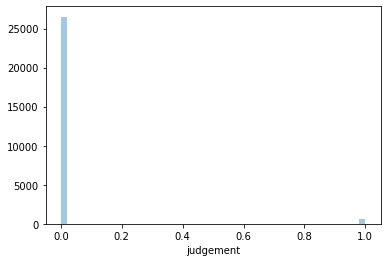

In [33]:
sns.distplot(train["judgement"], kde=False)

In [34]:
train["judgement"].value_counts()

0    26513
1      632
Name: judgement, dtype: int64

In [35]:
border = len(train[train["judgement"] == 1]) / len(train["judgement"])
print(border)

0.023282372444280715


### title の単語数の分布

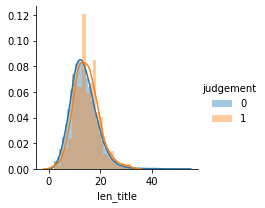

In [36]:
g = sns.FacetGrid(train[["judgement", "len_title"]], hue='judgement')
g.map(sns.distplot, 'len_title', label='judgement', hist=True, rug=False)
g.add_legend()

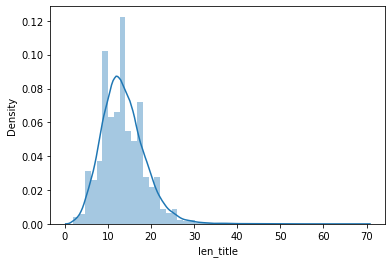

In [37]:
sns.distplot(test["len_title"], hist=True, rug=False)

### abstract の単語数の分布

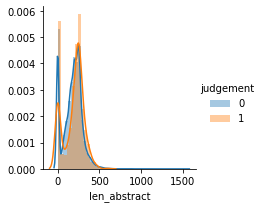

In [38]:
g = sns.FacetGrid(train[["judgement", "len_abstract"]], hue='judgement')
g.map(sns.distplot, 'len_abstract', label='judgement', hist=True, rug=False)
g.add_legend()

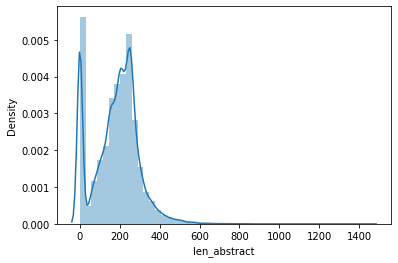

In [39]:
sns.distplot(test["len_abstract"], hist=True, rug=False)

## Load Models

In [40]:
if Config.validate:
    api = wandb.Api()

    for n, run_id in enumerate(config.inference_runs):
        if not os.path.exists(run_id):
            os.makedirs(run_id)

        run_path = f"{Config.wandb_entity}/{Config.wandb_project}/{run_id}"
        run = api.run(run_path)

        try:
            run.file("oof_df.csv").download(run_id)
        except wandb.CommError:
            # Already downloaded.
            pass

        oof = pd.read_csv(f"{run_id}/oof_df.csv")[["id", "preds"]]
        oof.columns = ["id", f"preds{n}"]
        train = pd.merge(train, oof, on="id")
    
    print(train.columns)

In [41]:
if Config.inference:
    api = wandb.Api()
    inference_models = []

    for n, run_id in enumerate(config.inference_runs):
        if not os.path.exists(run_id):
            os.makedirs(run_id)

        run_path = f"{Config.wandb_entity}/{Config.wandb_project}/{run_id}"
        run = api.run(run_path)

        inference_model = {}
        inference_model["run_id"] = run_id
        inference_model["model_name"] = run.config["model_name"]

        for fold in range(config.n_fold):
            try:
                run.file(f"{inference_model['model_name'].replace('/', '-')}_fold{fold}_best.pth").download(run_id)
            except wandb.CommError:
                # Already downloaded.
                pass

            model_preds = torch.load(f"{run_id}/{inference_model['model_name'].replace('/', '-')}_fold{fold}_best.pth")
            inference_model[f"state_fold{fold}"] = model_preds["model"]
            inference_model[f"preds_fold{fold}"] = model_preds["preds"]

        inference_models.append(inference_model)
    
    print({m['run_id']: m['model_name'] for m in inference_models})

In [42]:
if Config.debug:
    train = train.sample(n=1000, random_state=config.seed).reset_index(drop=True)
    test = test.sample(n=1000, random_state=config.seed).reset_index(drop=True)
    sub = sub.sample(n=1000, random_state=config.seed).reset_index(drop=True)

## CV Split

In [43]:
Fold = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train[["judgement", "nan_abstract"]])):
    train.loc[val_index, "fold"] = int(n)
train["fold"] = train["fold"].astype(np.uint8)
print(train.groupby(["fold", "judgement", "nan_abstract"]).size())

fold  judgement  nan_abstract
0     0          0               4456
                 1                847
      1          0                 95
                 1                 31
1     0          0               4444
                 1                858
      1          0                107
                 1                 20
2     0          0               4456
                 1                847
      1          0                 95
                 1                 31
3     0          0               4441
                 1                862
      1          0                110
                 1                 16
4     0          0               4448
                 1                854
      1          0                103
                 1                 24
dtype: int64


## Utils

In [44]:
@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=config.seed)


## Dataset

In [45]:
class BaseDataset(Dataset):
    def __init__(self, df, model_name, include_labels=True):
        tokenizer = T.AutoTokenizer.from_pretrained(model_name)

        self.df = df
        self.include_labels = include_labels

        self.title = df[config.input].tolist()
        self.encoded = tokenizer.batch_encode_plus(
            self.title,
            padding = 'max_length',            
            max_length = config.max_len,
            truncation = True,
            return_attention_mask=True
        )
        
        if self.include_labels:
            self.labels = df["judgement"].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.encoded['input_ids'][idx])
        attention_mask = torch.tensor(self.encoded['attention_mask'][idx])

        if self.include_labels:
            label = torch.tensor(self.labels[idx]).float()
            return input_ids, attention_mask, label

        return input_ids, attention_mask


In [46]:
# Test

if config.model_name != "":

    train_ds = BaseDataset(train, config.model_name)

    for i in range(1):
        input_ids, attention_mask, label = train_ds[i]
        print(input_ids)
        print(attention_mask)
        print(f"label: {label}")


tensor([  101, 23191,  2527,  5057,  1115,  6246,  1116,  1107,  1884, 25763,
         1105,  2962, 26872,  1170,  1425,  3102,  1201,   119,  1103, 24928,
        11955,  3906, 18778,  1596,  1105, 24928, 11955, 22192, 23652, 13791,
         1596,  1223,  6709,  3381,  1116,  1104, 12176,  1849,  1132, 10527,
         1112,  1175,  1110,  1376,  1869,  1113, 23191,  3575,  2607,   119,
         1195,  1132,  9239,   170, 23191, 24928, 11955,  8628,  3375,  2025,
         1104,  1664,  2007, 24674,  2214,  6635,  1107,  1103,   171,  1348,
         3121,  4982, 23191,  2025,  1104, 14195,   119,  1142,  2592,  7203,
         1113,  1425,  1105,  2673,  5408,  1107,  3575,  2401,  7140,  1118,
         8364, 20370, 14377,  1219,  1103,  1148,  1160,  2683, 10540,  1116,
          119,  2771,   118,  2237,  1348,  2686,  1121, 13096,  6635,  4079,
         4589,   118,  4859,  1201,  7063,  5409,  2610, 21828,  4907,  5552,
         6357,  1105,  2964,  5021,  1105,  1653,  2187,  6357, 

## Model

In [47]:
if config.model_name != "":
    print(T.AutoConfig.from_pretrained(config.model_name))

BertConfig {
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.9.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}



In [48]:
class BaseModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()

        if "base" in model_name or "L-12" in model_name:
            out_dim = 768
        elif "large" in model_name or "L-24" in model_name:
            out_dim = 1024

        auto_config = T.AutoConfig.from_pretrained(model_name)
        auto_config.update({
            "output_hidden_states": True,
            "hidden_dropout_prob": config.dropout,
            # "layer_norm_eps": 1e-7,
        })
        
        self.auto_model = T.AutoModel.from_pretrained(model_name, config=auto_config)  

        self.attention = nn.Sequential(
            nn.Linear(out_dim, 512),            
            nn.Tanh(),                       
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )        

        self.regressor = nn.Sequential(
            nn.Linear(out_dim, 1)                        
        )

        if config.reinit_layers > 0:
            self.re_init()

        if config.freeze_layers > 0:
            self.freeze()

    def forward(self, input_ids, attention_mask):
        bert_output = self.auto_model(input_ids=input_ids, attention_mask=attention_mask)        

        # There are a total of 13 layers of hidden states.
        # 1 for the embedding layer, and 12 for the 12 Roberta layers.
        # We take the hidden states from the last Roberta layer.
        last_layer_hidden_states = bert_output.hidden_states[-1]

        # The number of cells is config.max_len.
        # The size of the hidden state of each cell is 768 (for roberta-base).
        # In order to condense hidden states of all cells to a context vector,
        # we compute a weighted average of the hidden states of all cells.
        # We compute the weight of each cell, using the attention neural network.
        weights = self.attention(last_layer_hidden_states)
                
        # weights.shape is config.batch_size x config.max_len x 1
        # last_layer_hidden_states.shape is config.batch_size x config.max_len x 768        
        # Now we compute context_vector as the weighted average.
        # context_vector.shape is config.batch_size x 768
        context_vector = torch.sum(weights * last_layer_hidden_states, dim=1)        
        
        # Now we reduce the context vector to the prediction score.
        out = self.regressor(context_vector).squeeze()

        return out

    def re_init(self):
        # re-init pooler
        self.auto_model.pooler.dense.weight.data.normal_(mean=0.0, std=self.auto_model.config.initializer_range)
        self.auto_model.pooler.dense.bias.data.zero_()
        for p in self.auto_model.pooler.parameters():
            p.requires_grad = True

        # re-init encoder
        layers = self.auto_model.encoder.layer[-config.reinit_layers:]
        for layer in layers:
            for module in layer.modules():
                if isinstance(module, nn.Linear):
                    # Slightly different from the TF version which uses truncated_normal for initialization
                    # cf https://github.com/pytorch/pytorch/pull/5617
                    module.weight.data.normal_(mean=0.0, std=self.auto_model.config.initializer_range)
                    if module.bias is not None:
                        module.bias.data.zero_()
                elif isinstance(module, nn.Embedding):
                    module.weight.data.normal_(mean=0.0, std=self.auto_model.config.initializer_range)
                    if module.padding_idx is not None:
                        module.weight.data[module.padding_idx].zero_()
                elif isinstance(module, nn.LayerNorm):
                    module.bias.data.zero_()
                    module.weight.data.fill_(1.0)

    def freeze(self):
        # freeze embedding
        for param in self.auto_model.embeddings.parameters():
            param.requires_grad = False

        # freeze encoder
        layers = self.auto_model.encoder.layer[:config.freeze_layers]
        for layer in layers:
            for param in layer.parameters():
                param.requires_grad = False

In [49]:
# Test

if config.model_name != "":

    model = BaseModel(config.model_name)
    print(model)

    train_dataset = BaseDataset(train, config.model_name)
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

    for input_ids, attention_mask, labels in train_loader:
        output = model(input_ids, attention_mask)
        print(output)
        break


Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1-squad were not used when initializing BertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BaseModel(
  (auto_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [50]:
# Test

if config.model_name != "":
    for n, (name, tensor) in enumerate(list(model.named_parameters())):
        print(f"{n:>4}: {tensor.requires_grad}, {name}")

   0: True, auto_model.embeddings.word_embeddings.weight
   1: True, auto_model.embeddings.position_embeddings.weight
   2: True, auto_model.embeddings.token_type_embeddings.weight
   3: True, auto_model.embeddings.LayerNorm.weight
   4: True, auto_model.embeddings.LayerNorm.bias
   5: True, auto_model.encoder.layer.0.attention.self.query.weight
   6: True, auto_model.encoder.layer.0.attention.self.query.bias
   7: True, auto_model.encoder.layer.0.attention.self.key.weight
   8: True, auto_model.encoder.layer.0.attention.self.key.bias
   9: True, auto_model.encoder.layer.0.attention.self.value.weight
  10: True, auto_model.encoder.layer.0.attention.self.value.bias
  11: True, auto_model.encoder.layer.0.attention.output.dense.weight
  12: True, auto_model.encoder.layer.0.attention.output.dense.bias
  13: True, auto_model.encoder.layer.0.attention.output.LayerNorm.weight
  14: True, auto_model.encoder.layer.0.attention.output.LayerNorm.bias
  15: True, auto_model.encoder.layer.0.intermed

## Optimizer

In [51]:
def bert_optimizer(model):
    named_parameters = list(model.named_parameters())    
    
    if "albert-base" in config.model_name:
        bert_parameters = named_parameters[:23]    
        attention_parameters = named_parameters[25:29]
        regressor_parameters = named_parameters[29:]
        second_block = 999
        third_block = 999

    elif "base" in config.model_name or "L-12" in config.model_name:
        bert_parameters = named_parameters[:197]    
        attention_parameters = named_parameters[199:203]
        regressor_parameters = named_parameters[203:]
        second_block = 69
        third_block = 133

    elif "large" in config.model_name or "L-24" in config.model_name:
        bert_parameters = named_parameters[:388]    
        attention_parameters = named_parameters[391:395]
        regressor_parameters = named_parameters[395:]
        second_block = 133
        third_block = 261
        
    attention_group = [params for (name, params) in attention_parameters]
    regressor_group = [params for (name, params) in regressor_parameters]

    parameters = []
    parameters.append({"params": attention_group})
    parameters.append({"params": regressor_group})

    for layer_num, (name, params) in enumerate(bert_parameters):
        weight_decay = 0.0 if "bias" in name else config.weight_decay

        lr = config.lr

        if layer_num >= second_block:        
            lr = config.lr_69

        if layer_num >= third_block:
            lr = config.lr_133

        parameters.append({"params": params, "weight_decay": weight_decay, "lr": lr})

    return T.AdamW(parameters)


## Loss

In [52]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-7):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

In [53]:
# https://gist.github.com/SuperShinyEyes/dcc68a08ff8b615442e3bc6a9b55a354
class FBetaLoss(nn.Module):

    def __init__(self, beta=1.0, epsilon=1e-7):
        super().__init__()
        self.beta = beta
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true):
        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        beta_squared = self.beta ** 2
        fbeta = (1 + beta_squared) * precision * recall / (beta_squared * precision + recall + self.epsilon)
        fbeta = fbeta.clamp(min=self.epsilon, max=1-self.epsilon)
        return 1 - fbeta.mean()

## Scoring

In [54]:
def get_score(y_true, y_pred, b=border):
    y_pred = np.where(y_pred < b, 0, 1)
    return fbeta_score(y_true, y_pred, beta=7.0)

In [55]:
def get_result(result_df, fold=config.n_fold):
    preds = result_df["preds"].values
    labels = result_df["judgement"].values
    score = get_score(labels, preds)
    LOGGER.info(f"Score: {score:<.5f}")
    # wandb.log({"fold": fold, "CV": score})
    if fold == config.n_fold:
        wandb.run.summary[f"CV"] = score
    else:
        wandb.run.summary[f"CV_fold{fold}"] = score


In [56]:
def determine_border(b, y_true, y_pred):
    return -1 * get_score(y_true, y_pred, b)


## Helper functions

In [57]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

In [58]:
def pre_train_fn():
    tokenizer = T.AutoTokenizer.from_pretrained(config.model_name)
    model = T.AutoModelForMaskedLM.from_pretrained(config.model_name)

    tokenizer.save_pretrained(f"./pretrained_{config.model_name}")

    train_dataset = T.LineByLineTextDataset(tokenizer=tokenizer, file_path="abstracts.txt", block_size=512)
    valid_dataset = T.LineByLineTextDataset(tokenizer=tokenizer, file_path="abstracts.txt", block_size=512)

    data_collator = T.DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=True, mlm_probability=0.15
    )

    training_args = T.TrainingArguments(
        output_dir = f"./pretrained_{config.model_name}_chk",
        overwrite_output_dir = True,
        num_train_epochs = 5,
        per_device_train_batch_size = 4,
        per_device_eval_batch_size = 4,
        gradient_accumulation_steps = 4,
        evaluation_strategy = 'steps',
        save_total_limit = 2,
        eval_steps = 105,
        save_steps = 105,
        metric_for_best_model = 'eval_loss',
        greater_is_better = False,
        load_best_model_at_end = True,
        prediction_loss_only = True,
        report_to = "wandb",
    )

    trainer = T.Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
    )

    trainer.train()

    trainer.save_model(f"./pretrained_{config.model_name}")

In [59]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()

    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    optimizer.zero_grad()

    for step, (input_ids, attention_mask, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        y_preds = model(input_ids, attention_mask)

        loss = criterion(y_preds, labels)

        # record loss
        losses.update(loss.item(), batch_size)
        if config.gradient_accumulation_steps > 1:
            loss = loss / config.gradient_accumulation_steps
        if Config.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)

        if (step + 1) % config.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            else:
                scheduler.step()
            
            global_step += 1

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if step % Config.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                f"Epoch: [{epoch + 1}][{step}/{len(train_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(train_loader)):s} "
                f"Loss: {losses.avg:.4f} "
                f"Grad: {grad_norm:.4f} "
                # f"LR: {scheduler.get_last_lr()[0]:.6f}  "
                f"LR: {scheduler.get_lr()[0]:.6f}  "
            )

    return losses.avg

In [60]:
def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()

    for step, (input_ids, attention_mask, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        # compute loss
        with torch.no_grad():
            y_preds = model(input_ids, attention_mask)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # record score
        # preds.append(y_preds.softmax(1).to("cpu").numpy())
        preds.append(y_preds.to("cpu").numpy())
        if config.gradient_accumulation_steps > 1:
            loss = loss / config.gradient_accumulation_steps

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if step % Config.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                f"EVAL: [{step}/{len(valid_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(valid_loader)):s} "
                f"Loss: {losses.avg:.4f} "
            )
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [61]:
def inference():
    predictions = []

    for model_item in inference_models:
        test_dataset = BaseDataset(test, model_item['model_name'], include_labels=False)
        test_loader = DataLoader(
            test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True
        )

        for fold in range(config.n_fold):
            LOGGER.info(f"========== ID: {model_item['run_id']} model: {model_item['model_name']} fold: {fold} inference ==========")
            model = BaseModel(model_item['model_name'])
            model.to(device)
            model.load_state_dict(model_item[f"state_fold{fold}"])
            model.eval()
            preds = []
            for i, (input_ids, attention_mask) in tqdm(enumerate(test_loader), total=len(test_loader)):
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                with torch.no_grad():
                    y_preds = model(input_ids, attention_mask)
                # avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
                preds.append(y_preds.to("cpu").numpy())
            preds = np.concatenate(preds)
            predictions.append(preds)
    predictions = np.mean(predictions, axis=0)

    if config.criterion == "BCEWithLogitsLoss":
        predictions = 1 / (1 + np.exp(-predictions))

    return predictions


## Train loop

In [62]:
def train_loop(df, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = df[df["fold"] != fold].index
    val_idx = df[df["fold"] == fold].index

    train_folds = df.loc[trn_idx].reset_index(drop=True)
    valid_folds = df.loc[val_idx].reset_index(drop=True)

    train_dataset = BaseDataset(train_folds, config.model_name)
    valid_dataset = BaseDataset(valid_folds, config.model_name)

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # Optimizer
    # ====================================================
    def get_optimizer(model):
        if config.optimizer == "Adam":
            optimizer = Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay, amsgrad=False)
        elif config.optimizer == "AdamW":
            optimizer = T.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        elif config.optimizer == "BertAdamW":
            optimizer = bert_optimizer(model)
        return optimizer

    # ====================================================
    # Scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if config.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=config.factor, patience=config.patience, verbose=True, eps=config.eps
            )
        elif config.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=config.T_max, eta_min=config.min_lr, last_epoch=-1)
        elif config.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(
                optimizer, T_0=config.T_0, T_mult=1, eta_min=config.min_lr, last_epoch=-1
            )
        elif config.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer, first_cycle_steps=config.first_cycle_steps, max_lr=config.lr, min_lr=config.min_lr, warmup_steps=config.warmup_steps
            )
        elif config.scheduler == "get_cosine_schedule_with_warmup":
            scheduler = T.get_cosine_schedule_with_warmup(
                optimizer,
                num_training_steps=config.num_training_steps, 
                num_warmup_steps=config.num_warmup_steps
            )
        return scheduler

    # ====================================================
    # Model
    # ====================================================
    model = BaseModel(config.model_name)
    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda") and not Config.apex and Config.multi_gpu:
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = get_optimizer(model)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # Apex
    # ====================================================
    if Config.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if config.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif config.criterion == "BCEWithLogitsLoss":
            criterion = nn.BCEWithLogitsLoss()
        elif config.criterion == "MSELoss":
            criterion = nn.MSELoss()
        elif config.criterion == "RMSELoss":
            criterion = RMSELoss()
        elif config.criterion == "FBetaLoss":
            criterion = FBetaLoss(7.0)

        return criterion

    criterion = get_criterion()

    # ====================================================
    # Loop
    # ====================================================
    best_score = -1
    best_loss = np.inf

    # if not Config.multi_gpu:
    #     wandb.watch(model, log_freq=Config.print_freq)

    for epoch in range(config.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds["judgement"].values

        # if isinstance(scheduler, ReduceLROnPlateau):
        #     scheduler.step(avg_val_loss)
        # else:
        #     scheduler.step()

        if config.criterion == "BCEWithLogitsLoss":
            preds = 1 / (1 + np.exp(-preds))

        # scoring
        # score = get_score(valid_labels, preds.argmax(1))
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

        wandb.log(
            {
                "epoch": epoch + 1,
                f"loss/train_fold{fold}": avg_loss,
                f"loss/val_fold{fold}": avg_val_loss,
                f"score/fold{fold}": score,
            }
        )

        if score > best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{config.model_name.replace('/', '-')}_fold{fold}_best.pth"
            )
            wandb.save(OUTPUT_DIR + f"{config.model_name.replace('/', '-')}_fold{fold}_best.pth")

        # if epoch == config.epochs - 1:
        #     LOGGER.info(f"Epoch {epoch+1} - Save final model")
        #     torch.save(
        #         {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{config.model_name}_fold{fold}_final.pth"
        #     )

    check_point = torch.load(OUTPUT_DIR + f"{config.model_name.replace('/', '-')}_fold{fold}_best.pth")

    valid_folds[[str(c) for c in range(config.n_class)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"]  # .argmax(1)

    return valid_folds

## Main


In [63]:
def main():
    if Config.pre_train:
        abstract_df = pd.concat([train["abstract"], test["abstract"]])
        abstracts  = '\n'.join(abstract_df.tolist())
        with open("abstracts.txt", "w") as f:
            f.write(abstracts)

        pre_train_fn()

    if Config.train:
        oof_df = pd.DataFrame()
        for fold in range(config.n_fold):
            seed_torch(seed + fold)

            _oof_df = train_loop(train, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df, fold)
            
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "oof_df.csv")
        
    if Config.validate:
        probs = []

        for n in range(len(config.inference_runs)):
            probs.append(train[f"preds{n}"].values)
        preds = np.mean(probs, axis=0)
        train["preds"] = preds

        # Post process
        if config.border == "minimize":
            res = sp.optimize.minimize_scalar(determine_border, method='bounded', bounds=(0, 1), args=(train["judgement"].values, preds))
            LOGGER.info(f"========== Border Optimization ==========")
            LOGGER.info(f"Border: {res.x:<.5f}, Score: {-res.fun:<.5f}")
            wandb.run.summary[f"CV"] = -res.fun

        elif config.border == "fixed":
            # CV result
            LOGGER.info(f"========== CV ==========")
            get_result(train)

        # save result
        train.to_csv(OUTPUT_DIR + "validation_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "validation_df.csv")

    if Config.inference:
        predictions = inference()

        # Post process
        try:
            b = res.x
        except Exception:
            b = border
        wandb.run.summary[f"border"] = b

        predictions = np.where(predictions < b, 0, 1)

        # submission
        sub["judgement"] = predictions  # .argmax(1)
        print(sub["judgement"].value_counts())

        sub.to_csv(OUTPUT_DIR + "submission.csv", index=False, header=False)
        wandb.save(OUTPUT_DIR + "submission.csv")


In [64]:
if __name__ == "__main__":
    main()


========== fold: 0 training ==========
Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1-squad were not used when initializing BertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1809] Elapsed 0m 1s (remain 31m 39s) Loss: 0.4759 Grad: 3.7578 LR: 0.000000  
Epoch: [1][100/1809] Elapsed 0m 37s (remain 10m 32s) Loss: 0.2216 Grad: 0.2570 LR: 0.000185  
Epoch: [1][200/1809] Elapsed 1m 13s (remain 9m 50s) Loss: 0.1582 Grad: 0.1371 LR: 0.000369  
Epoch: [1][300/1809] Elapsed 1m 50s (remain 9m 13s) Loss: 0.1356 Grad: 0.1279 LR: 0.000554  
Epoch: [1][400/1809] Elapsed 2m 26s (remain 8m 35s) Loss: 0.1210 Grad: 0.1662 LR: 0.000738  
Epoch: [1][500/1809] Elapsed 3m 3s (remain 7m 59s) Loss: 0.1177 Grad: 0.1690 LR: 0.000923  
Epoch: [1][600/1809] Elapsed 3m 40s (remain 7m 22s) Loss: 0.1114 Grad: 0.0593 LR: 0.001000  
Epoch: [1][700/1809] Elapsed 4m 16s (remain 6m 45s) Loss: 0.1054 Grad: 0.0944 LR: 0.000997  
Epoch: [1][800/1809] Elapsed 4m 53s (remain 6m 8s) Loss: 0.1031 Grad: 0.0087 LR: 0.000993  
Epoch: [1][900/1809] Elapsed 5m 29s (remain 5m 32s) Loss: 0.1029 Grad: 0.5357 LR: 0.000987  
Epoch: [1][1000/1809] Elapsed 6m 6s (remain 4m 55s) Loss: 0.1005 Grad: 1.

Epoch 1 - avg_train_loss: 0.0792  avg_val_loss: 0.0452  time: 717s
Epoch 1 - Score: 0.8849557522123894
Epoch 1 - Save Best Score: 0.8850 Model


Epoch: [2][0/1809] Elapsed 0m 1s (remain 55m 54s) Loss: 0.0181 Grad: 0.1483 LR: 0.000843  
Epoch: [2][100/1809] Elapsed 0m 38s (remain 10m 50s) Loss: 0.0366 Grad: 0.2815 LR: 0.000819  
Epoch: [2][200/1809] Elapsed 1m 15s (remain 10m 0s) Loss: 0.0358 Grad: 0.0118 LR: 0.000794  
Epoch: [2][300/1809] Elapsed 1m 51s (remain 9m 18s) Loss: 0.0369 Grad: 0.0076 LR: 0.000767  
Epoch: [2][400/1809] Elapsed 2m 28s (remain 8m 40s) Loss: 0.0366 Grad: 0.0036 LR: 0.000739  
Epoch: [2][500/1809] Elapsed 3m 4s (remain 8m 2s) Loss: 0.0372 Grad: 0.5696 LR: 0.000710  
Epoch: [2][600/1809] Elapsed 3m 41s (remain 7m 24s) Loss: 0.0389 Grad: 0.1164 LR: 0.000681  
Epoch: [2][700/1809] Elapsed 4m 17s (remain 6m 47s) Loss: 0.0391 Grad: 0.0054 LR: 0.000650  
Epoch: [2][800/1809] Elapsed 4m 54s (remain 6m 10s) Loss: 0.0374 Grad: 0.0880 LR: 0.000619  
Epoch: [2][900/1809] Elapsed 5m 30s (remain 5m 33s) Loss: 0.0364 Grad: 0.3575 LR: 0.000588  
Epoch: [2][1000/1809] Elapsed 6m 7s (remain 4m 56s) Loss: 0.0361 Grad: 0.

Epoch 2 - avg_train_loss: 0.0326  avg_val_loss: 0.0427  time: 718s
Epoch 2 - Score: 0.8396827865028766


Epoch: [3][0/1809] Elapsed 0m 0s (remain 29m 57s) Loss: 0.0052 Grad: 0.3182 LR: 0.000302  
Epoch: [3][100/1809] Elapsed 0m 37s (remain 10m 34s) Loss: 0.0190 Grad: 0.0013 LR: 0.000273  
Epoch: [3][200/1809] Elapsed 1m 14s (remain 9m 52s) Loss: 0.0163 Grad: 0.0975 LR: 0.000245  
Epoch: [3][300/1809] Elapsed 1m 50s (remain 9m 14s) Loss: 0.0164 Grad: 0.0022 LR: 0.000218  
Epoch: [3][400/1809] Elapsed 2m 27s (remain 8m 37s) Loss: 0.0179 Grad: 0.0092 LR: 0.000192  
Epoch: [3][500/1809] Elapsed 3m 3s (remain 7m 59s) Loss: 0.0177 Grad: 0.0851 LR: 0.000167  
Epoch: [3][600/1809] Elapsed 3m 40s (remain 7m 22s) Loss: 0.0174 Grad: 0.0215 LR: 0.000144  
Epoch: [3][700/1809] Elapsed 4m 16s (remain 6m 45s) Loss: 0.0173 Grad: 0.0015 LR: 0.000122  
Epoch: [3][800/1809] Elapsed 4m 53s (remain 6m 9s) Loss: 0.0169 Grad: 0.0018 LR: 0.000102  
Epoch: [3][900/1809] Elapsed 5m 29s (remain 5m 32s) Loss: 0.0159 Grad: 0.0024 LR: 0.000083  
Epoch: [3][1000/1809] Elapsed 6m 6s (remain 4m 55s) Loss: 0.0162 Grad: 0.

Epoch 3 - avg_train_loss: 0.0141  avg_val_loss: 0.0450  time: 717s
Epoch 3 - Score: 0.8377701221421859
========== fold: 0 result ==========
Score: 0.88496
========== fold: 1 training ==========
Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1-squad were not used when initializing BertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1809] Elapsed 0m 1s (remain 31m 55s) Loss: 0.6736 Grad: 4.3842 LR: 0.000000  
Epoch: [1][100/1809] Elapsed 0m 37s (remain 10m 34s) Loss: 0.2707 Grad: 1.7780 LR: 0.000185  
Epoch: [1][200/1809] Elapsed 1m 14s (remain 9m 52s) Loss: 0.1918 Grad: 0.4861 LR: 0.000369  
Epoch: [1][300/1809] Elapsed 1m 50s (remain 9m 13s) Loss: 0.1533 Grad: 0.3596 LR: 0.000554  
Epoch: [1][400/1809] Elapsed 2m 27s (remain 8m 36s) Loss: 0.1350 Grad: 1.6554 LR: 0.000738  
Epoch: [1][500/1809] Elapsed 3m 3s (remain 7m 59s) Loss: 0.1217 Grad: 0.4074 LR: 0.000923  
Epoch: [1][600/1809] Elapsed 3m 40s (remain 7m 22s) Loss: 0.1136 Grad: 0.3791 LR: 0.001000  
Epoch: [1][700/1809] Elapsed 4m 16s (remain 6m 45s) Loss: 0.1092 Grad: 0.0866 LR: 0.000997  
Epoch: [1][800/1809] Elapsed 4m 53s (remain 6m 9s) Loss: 0.1049 Grad: 0.7590 LR: 0.000993  
Epoch: [1][900/1809] Elapsed 5m 29s (remain 5m 32s) Loss: 0.0999 Grad: 0.3071 LR: 0.000987  
Epoch: [1][1000/1809] Elapsed 6m 6s (remain 4m 55s) Loss: 0.0961 Grad: 0.

Epoch 1 - avg_train_loss: 0.0783  avg_val_loss: 0.0485  time: 717s
Epoch 1 - Score: 0.8498188910560044
Epoch 1 - Save Best Score: 0.8498 Model


Epoch: [2][0/1809] Elapsed 0m 1s (remain 32m 52s) Loss: 0.2103 Grad: 1.9549 LR: 0.000843  
Epoch: [2][100/1809] Elapsed 0m 37s (remain 10m 37s) Loss: 0.0436 Grad: 0.4424 LR: 0.000819  
Epoch: [2][200/1809] Elapsed 1m 14s (remain 9m 53s) Loss: 0.0386 Grad: 0.1802 LR: 0.000794  
Epoch: [2][300/1809] Elapsed 1m 50s (remain 9m 15s) Loss: 0.0335 Grad: 0.0064 LR: 0.000767  
Epoch: [2][400/1809] Elapsed 2m 27s (remain 8m 37s) Loss: 0.0356 Grad: 0.0095 LR: 0.000739  
Epoch: [2][500/1809] Elapsed 3m 4s (remain 8m 0s) Loss: 0.0355 Grad: 0.0028 LR: 0.000710  
Epoch: [2][600/1809] Elapsed 3m 40s (remain 7m 23s) Loss: 0.0340 Grad: 0.8575 LR: 0.000681  
Epoch: [2][700/1809] Elapsed 4m 17s (remain 6m 46s) Loss: 0.0327 Grad: 0.0054 LR: 0.000650  
Epoch: [2][800/1809] Elapsed 4m 53s (remain 6m 9s) Loss: 0.0323 Grad: 0.3256 LR: 0.000619  
Epoch: [2][900/1809] Elapsed 5m 30s (remain 5m 32s) Loss: 0.0340 Grad: 0.3541 LR: 0.000588  
Epoch: [2][1000/1809] Elapsed 6m 6s (remain 4m 56s) Loss: 0.0336 Grad: 0.1

Epoch 2 - avg_train_loss: 0.0337  avg_val_loss: 0.0352  time: 718s
Epoch 2 - Score: 0.8873456790123457
Epoch 2 - Save Best Score: 0.8873 Model


Epoch: [3][0/1809] Elapsed 0m 1s (remain 31m 21s) Loss: 0.0008 Grad: 0.0204 LR: 0.000302  
Epoch: [3][100/1809] Elapsed 0m 37s (remain 10m 36s) Loss: 0.0159 Grad: 0.0606 LR: 0.000273  
Epoch: [3][200/1809] Elapsed 1m 14s (remain 9m 54s) Loss: 0.0135 Grad: 0.0110 LR: 0.000245  
Epoch: [3][300/1809] Elapsed 1m 50s (remain 9m 15s) Loss: 0.0144 Grad: 1.5716 LR: 0.000218  
Epoch: [3][400/1809] Elapsed 2m 27s (remain 8m 37s) Loss: 0.0153 Grad: 0.0032 LR: 0.000192  
Epoch: [3][500/1809] Elapsed 3m 4s (remain 8m 0s) Loss: 0.0156 Grad: 0.1465 LR: 0.000167  
Epoch: [3][600/1809] Elapsed 3m 40s (remain 7m 23s) Loss: 0.0152 Grad: 0.0207 LR: 0.000144  
Epoch: [3][700/1809] Elapsed 4m 17s (remain 6m 46s) Loss: 0.0157 Grad: 0.3690 LR: 0.000122  
Epoch: [3][800/1809] Elapsed 4m 53s (remain 6m 9s) Loss: 0.0153 Grad: 0.0039 LR: 0.000102  
Epoch: [3][900/1809] Elapsed 5m 30s (remain 5m 33s) Loss: 0.0155 Grad: 0.0025 LR: 0.000083  
Epoch: [3][1000/1809] Elapsed 6m 7s (remain 4m 56s) Loss: 0.0157 Grad: 2.8

Epoch 3 - avg_train_loss: 0.0153  avg_val_loss: 0.0388  time: 718s
Epoch 3 - Score: 0.8634100808960795
========== fold: 1 result ==========
Score: 0.88735
========== fold: 2 training ==========
Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1-squad were not used when initializing BertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1809] Elapsed 0m 1s (remain 30m 44s) Loss: 0.7004 Grad: 3.2719 LR: 0.000000  
Epoch: [1][100/1809] Elapsed 0m 37s (remain 10m 34s) Loss: 0.2606 Grad: 0.8401 LR: 0.000185  
Epoch: [1][200/1809] Elapsed 1m 14s (remain 9m 52s) Loss: 0.1793 Grad: 0.1962 LR: 0.000369  
Epoch: [1][300/1809] Elapsed 1m 50s (remain 9m 14s) Loss: 0.1624 Grad: 0.6565 LR: 0.000554  
Epoch: [1][400/1809] Elapsed 2m 27s (remain 8m 37s) Loss: 0.1409 Grad: 0.0538 LR: 0.000738  
Epoch: [1][500/1809] Elapsed 3m 3s (remain 8m 0s) Loss: 0.1285 Grad: 0.1151 LR: 0.000923  
Epoch: [1][600/1809] Elapsed 3m 40s (remain 7m 22s) Loss: 0.1202 Grad: 0.6531 LR: 0.001000  
Epoch: [1][700/1809] Elapsed 4m 16s (remain 6m 46s) Loss: 0.1134 Grad: 0.7503 LR: 0.000997  
Epoch: [1][800/1809] Elapsed 4m 53s (remain 6m 9s) Loss: 0.1064 Grad: 0.1262 LR: 0.000993  
Epoch: [1][900/1809] Elapsed 5m 30s (remain 5m 32s) Loss: 0.1015 Grad: 1.7964 LR: 0.000987  
Epoch: [1][1000/1809] Elapsed 6m 6s (remain 4m 56s) Loss: 0.0971 Grad: 0.6

Epoch 1 - avg_train_loss: 0.0760  avg_val_loss: 0.0427  time: 718s
Epoch 1 - Score: 0.9090909090909092
Epoch 1 - Save Best Score: 0.9091 Model


Epoch: [2][0/1809] Elapsed 0m 1s (remain 33m 38s) Loss: 0.0023 Grad: 0.0657 LR: 0.000843  
Epoch: [2][100/1809] Elapsed 0m 37s (remain 10m 36s) Loss: 0.0410 Grad: 0.0331 LR: 0.000819  
Epoch: [2][200/1809] Elapsed 1m 14s (remain 9m 53s) Loss: 0.0429 Grad: 0.4638 LR: 0.000794  
Epoch: [2][300/1809] Elapsed 1m 50s (remain 9m 14s) Loss: 0.0423 Grad: 0.6667 LR: 0.000767  
Epoch: [2][400/1809] Elapsed 2m 27s (remain 8m 37s) Loss: 0.0381 Grad: 0.0369 LR: 0.000739  
Epoch: [2][500/1809] Elapsed 3m 3s (remain 8m 0s) Loss: 0.0369 Grad: 0.0507 LR: 0.000710  
Epoch: [2][600/1809] Elapsed 3m 40s (remain 7m 23s) Loss: 0.0355 Grad: 0.5031 LR: 0.000681  
Epoch: [2][700/1809] Elapsed 4m 16s (remain 6m 46s) Loss: 0.0372 Grad: 0.5620 LR: 0.000650  
Epoch: [2][800/1809] Elapsed 4m 53s (remain 6m 9s) Loss: 0.0379 Grad: 0.0874 LR: 0.000619  
Epoch: [2][900/1809] Elapsed 5m 30s (remain 5m 32s) Loss: 0.0366 Grad: 0.0298 LR: 0.000588  
Epoch: [2][1000/1809] Elapsed 6m 6s (remain 4m 55s) Loss: 0.0369 Grad: 0.9

Epoch 2 - avg_train_loss: 0.0329  avg_val_loss: 0.0342  time: 718s
Epoch 2 - Score: 0.9290540540540542
Epoch 2 - Save Best Score: 0.9291 Model


Epoch: [3][0/1809] Elapsed 0m 1s (remain 31m 36s) Loss: 0.0002 Grad: 0.0021 LR: 0.000302  
Epoch: [3][100/1809] Elapsed 0m 37s (remain 10m 35s) Loss: 0.0121 Grad: 0.0651 LR: 0.000273  
Epoch: [3][200/1809] Elapsed 1m 14s (remain 9m 53s) Loss: 0.0113 Grad: 0.0088 LR: 0.000245  
Epoch: [3][300/1809] Elapsed 1m 50s (remain 9m 14s) Loss: 0.0119 Grad: 1.1448 LR: 0.000218  
Epoch: [3][400/1809] Elapsed 2m 27s (remain 8m 37s) Loss: 0.0117 Grad: 0.0017 LR: 0.000192  
Epoch: [3][500/1809] Elapsed 3m 3s (remain 8m 0s) Loss: 0.0131 Grad: 0.0050 LR: 0.000167  
Epoch: [3][600/1809] Elapsed 3m 40s (remain 7m 23s) Loss: 0.0133 Grad: 0.0266 LR: 0.000144  
Epoch: [3][700/1809] Elapsed 4m 17s (remain 6m 46s) Loss: 0.0135 Grad: 0.0069 LR: 0.000122  
Epoch: [3][800/1809] Elapsed 4m 53s (remain 6m 9s) Loss: 0.0140 Grad: 0.0078 LR: 0.000102  
Epoch: [3][900/1809] Elapsed 5m 30s (remain 5m 32s) Loss: 0.0140 Grad: 0.6760 LR: 0.000083  
Epoch: [3][1000/1809] Elapsed 6m 6s (remain 4m 56s) Loss: 0.0148 Grad: 0.0

Epoch 3 - avg_train_loss: 0.0139  avg_val_loss: 0.0366  time: 717s
Epoch 3 - Score: 0.9105058365758755
========== fold: 2 result ==========
Score: 0.92905
========== fold: 3 training ==========
Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1-squad were not used when initializing BertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1809] Elapsed 0m 1s (remain 30m 26s) Loss: 0.4627 Grad: 3.6732 LR: 0.000000  
Epoch: [1][100/1809] Elapsed 0m 37s (remain 10m 34s) Loss: 0.1952 Grad: 0.9052 LR: 0.000185  
Epoch: [1][200/1809] Elapsed 1m 14s (remain 9m 52s) Loss: 0.1502 Grad: 0.1502 LR: 0.000369  
Epoch: [1][300/1809] Elapsed 1m 50s (remain 9m 14s) Loss: 0.1355 Grad: 0.1088 LR: 0.000554  
Epoch: [1][400/1809] Elapsed 2m 27s (remain 8m 36s) Loss: 0.1295 Grad: 1.0069 LR: 0.000738  
Epoch: [1][500/1809] Elapsed 3m 3s (remain 7m 59s) Loss: 0.1187 Grad: 0.0680 LR: 0.000923  
Epoch: [1][600/1809] Elapsed 3m 40s (remain 7m 22s) Loss: 0.1123 Grad: 0.0601 LR: 0.001000  
Epoch: [1][700/1809] Elapsed 4m 16s (remain 6m 45s) Loss: 0.1055 Grad: 0.1576 LR: 0.000997  
Epoch: [1][800/1809] Elapsed 4m 53s (remain 6m 9s) Loss: 0.1027 Grad: 0.0123 LR: 0.000993  
Epoch: [1][900/1809] Elapsed 5m 29s (remain 5m 32s) Loss: 0.0977 Grad: 0.1551 LR: 0.000987  
Epoch: [1][1000/1809] Elapsed 6m 6s (remain 4m 55s) Loss: 0.0943 Grad: 0.

Epoch 1 - avg_train_loss: 0.0786  avg_val_loss: 0.0456  time: 717s
Epoch 1 - Score: 0.8840115836000609
Epoch 1 - Save Best Score: 0.8840 Model


Epoch: [2][0/1809] Elapsed 0m 1s (remain 31m 55s) Loss: 0.0006 Grad: 0.0082 LR: 0.000843  
Epoch: [2][100/1809] Elapsed 0m 37s (remain 10m 36s) Loss: 0.0338 Grad: 0.0103 LR: 0.000819  
Epoch: [2][200/1809] Elapsed 1m 14s (remain 9m 52s) Loss: 0.0375 Grad: 0.0101 LR: 0.000794  
Epoch: [2][300/1809] Elapsed 1m 50s (remain 9m 14s) Loss: 0.0337 Grad: 0.0046 LR: 0.000767  
Epoch: [2][400/1809] Elapsed 2m 27s (remain 8m 36s) Loss: 0.0318 Grad: 0.0445 LR: 0.000739  
Epoch: [2][500/1809] Elapsed 3m 3s (remain 7m 59s) Loss: 0.0322 Grad: 0.0032 LR: 0.000710  
Epoch: [2][600/1809] Elapsed 3m 40s (remain 7m 22s) Loss: 0.0346 Grad: 1.8065 LR: 0.000681  
Epoch: [2][700/1809] Elapsed 4m 16s (remain 6m 45s) Loss: 0.0354 Grad: 0.4543 LR: 0.000650  
Epoch: [2][800/1809] Elapsed 4m 53s (remain 6m 9s) Loss: 0.0345 Grad: 2.9728 LR: 0.000619  
Epoch: [2][900/1809] Elapsed 5m 29s (remain 5m 32s) Loss: 0.0338 Grad: 0.0265 LR: 0.000588  
Epoch: [2][1000/1809] Elapsed 6m 6s (remain 4m 55s) Loss: 0.0337 Grad: 0.

Epoch 2 - avg_train_loss: 0.0348  avg_val_loss: 0.0425  time: 717s
Epoch 2 - Score: 0.9047405413488858
Epoch 2 - Save Best Score: 0.9047 Model


Epoch: [3][0/1809] Elapsed 0m 1s (remain 31m 11s) Loss: 0.0272 Grad: 0.5433 LR: 0.000302  
Epoch: [3][100/1809] Elapsed 0m 37s (remain 10m 35s) Loss: 0.0185 Grad: 0.0386 LR: 0.000273  
Epoch: [3][200/1809] Elapsed 1m 14s (remain 9m 52s) Loss: 0.0199 Grad: 0.0015 LR: 0.000245  
Epoch: [3][300/1809] Elapsed 1m 50s (remain 9m 14s) Loss: 0.0205 Grad: 2.8206 LR: 0.000218  
Epoch: [3][400/1809] Elapsed 2m 27s (remain 8m 36s) Loss: 0.0192 Grad: 0.7539 LR: 0.000192  
Epoch: [3][500/1809] Elapsed 3m 3s (remain 7m 59s) Loss: 0.0190 Grad: 0.0008 LR: 0.000167  
Epoch: [3][600/1809] Elapsed 3m 40s (remain 7m 22s) Loss: 0.0183 Grad: 0.0372 LR: 0.000144  
Epoch: [3][700/1809] Elapsed 4m 16s (remain 6m 46s) Loss: 0.0190 Grad: 0.0710 LR: 0.000122  
Epoch: [3][800/1809] Elapsed 4m 53s (remain 6m 9s) Loss: 0.0186 Grad: 0.5238 LR: 0.000102  
Epoch: [3][900/1809] Elapsed 5m 30s (remain 5m 32s) Loss: 0.0175 Grad: 0.0007 LR: 0.000083  
Epoch: [3][1000/1809] Elapsed 6m 6s (remain 4m 55s) Loss: 0.0172 Grad: 0.

Epoch 3 - avg_train_loss: 0.0183  avg_val_loss: 0.0459  time: 717s
Epoch 3 - Score: 0.852052672347018
========== fold: 3 result ==========
Score: 0.90474
========== fold: 4 training ==========
Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1-squad were not used when initializing BertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1809] Elapsed 0m 0s (remain 29m 38s) Loss: 0.7772 Grad: 5.2457 LR: 0.000000  
Epoch: [1][100/1809] Elapsed 0m 37s (remain 10m 33s) Loss: 0.2785 Grad: 0.0915 LR: 0.000185  
Epoch: [1][200/1809] Elapsed 1m 14s (remain 9m 52s) Loss: 0.1946 Grad: 0.7696 LR: 0.000369  
Epoch: [1][300/1809] Elapsed 1m 50s (remain 9m 13s) Loss: 0.1696 Grad: 0.8224 LR: 0.000554  
Epoch: [1][400/1809] Elapsed 2m 27s (remain 8m 36s) Loss: 0.1606 Grad: 0.3395 LR: 0.000738  
Epoch: [1][500/1809] Elapsed 3m 3s (remain 7m 59s) Loss: 0.1496 Grad: 0.2190 LR: 0.000923  
Epoch: [1][600/1809] Elapsed 3m 40s (remain 7m 22s) Loss: 0.1376 Grad: 1.2606 LR: 0.001000  
Epoch: [1][700/1809] Elapsed 4m 16s (remain 6m 46s) Loss: 0.1298 Grad: 0.8783 LR: 0.000997  
Epoch: [1][800/1809] Elapsed 4m 53s (remain 6m 9s) Loss: 0.1207 Grad: 0.1334 LR: 0.000993  
Epoch: [1][900/1809] Elapsed 5m 30s (remain 5m 32s) Loss: 0.1117 Grad: 0.3164 LR: 0.000987  
Epoch: [1][1000/1809] Elapsed 6m 6s (remain 4m 55s) Loss: 0.1050 Grad: 1.

Epoch 1 - avg_train_loss: 0.0858  avg_val_loss: 0.0545  time: 717s
Epoch 1 - Score: 0.82249140122626
Epoch 1 - Save Best Score: 0.8225 Model


Epoch: [2][0/1809] Elapsed 0m 1s (remain 33m 6s) Loss: 0.0054 Grad: 0.0556 LR: 0.000843  
Epoch: [2][100/1809] Elapsed 0m 37s (remain 10m 37s) Loss: 0.0513 Grad: 0.9532 LR: 0.000819  
Epoch: [2][200/1809] Elapsed 1m 14s (remain 9m 53s) Loss: 0.0455 Grad: 0.2018 LR: 0.000794  
Epoch: [2][300/1809] Elapsed 1m 50s (remain 9m 15s) Loss: 0.0445 Grad: 0.0455 LR: 0.000767  
Epoch: [2][400/1809] Elapsed 2m 27s (remain 8m 37s) Loss: 0.0438 Grad: 1.4746 LR: 0.000739  
Epoch: [2][500/1809] Elapsed 3m 3s (remain 8m 0s) Loss: 0.0401 Grad: 0.0640 LR: 0.000710  
Epoch: [2][600/1809] Elapsed 3m 40s (remain 7m 23s) Loss: 0.0384 Grad: 0.0258 LR: 0.000681  
Epoch: [2][700/1809] Elapsed 4m 17s (remain 6m 46s) Loss: 0.0375 Grad: 0.1717 LR: 0.000650  
Epoch: [2][800/1809] Elapsed 4m 53s (remain 6m 9s) Loss: 0.0376 Grad: 3.7147 LR: 0.000619  
Epoch: [2][900/1809] Elapsed 5m 30s (remain 5m 32s) Loss: 0.0383 Grad: 1.0721 LR: 0.000588  
Epoch: [2][1000/1809] Elapsed 6m 6s (remain 4m 56s) Loss: 0.0375 Grad: 1.27

Epoch 2 - avg_train_loss: 0.0348  avg_val_loss: 0.0434  time: 718s
Epoch 2 - Score: 0.8632543926661572
Epoch 2 - Save Best Score: 0.8633 Model


Epoch: [3][0/1809] Elapsed 0m 1s (remain 31m 44s) Loss: 0.0016 Grad: 0.0399 LR: 0.000302  
Epoch: [3][100/1809] Elapsed 0m 37s (remain 10m 36s) Loss: 0.0241 Grad: 0.0431 LR: 0.000273  
Epoch: [3][200/1809] Elapsed 1m 14s (remain 9m 53s) Loss: 0.0224 Grad: 0.0384 LR: 0.000245  
Epoch: [3][300/1809] Elapsed 1m 50s (remain 9m 14s) Loss: 0.0207 Grad: 0.3564 LR: 0.000218  
Epoch: [3][400/1809] Elapsed 2m 27s (remain 8m 37s) Loss: 0.0190 Grad: 0.0018 LR: 0.000192  
Epoch: [3][500/1809] Elapsed 3m 3s (remain 8m 0s) Loss: 0.0187 Grad: 0.0023 LR: 0.000167  
Epoch: [3][600/1809] Elapsed 3m 40s (remain 7m 23s) Loss: 0.0177 Grad: 0.0931 LR: 0.000144  
Epoch: [3][700/1809] Elapsed 4m 17s (remain 6m 46s) Loss: 0.0166 Grad: 0.0013 LR: 0.000122  
Epoch: [3][800/1809] Elapsed 4m 53s (remain 6m 9s) Loss: 0.0155 Grad: 0.0010 LR: 0.000102  
Epoch: [3][900/1809] Elapsed 5m 30s (remain 5m 32s) Loss: 0.0155 Grad: 0.0167 LR: 0.000083  
Epoch: [3][1000/1809] Elapsed 6m 6s (remain 4m 55s) Loss: 0.0150 Grad: 0.0

Epoch 3 - avg_train_loss: 0.0144  avg_val_loss: 0.0511  time: 717s
Epoch 3 - Score: 0.8134490238611713
========== fold: 4 result ==========
Score: 0.86325
========== CV ==========
Score: 0.89377


In [65]:
wandb.finish()

epoch,3
loss/train_fold0,0.01408
loss/val_fold0,0.04504
score/fold0,0.83777
_runtime,11014
_timestamp,1628320805
_step,14
CV_fold0,0.88496
loss/train_fold1,0.01528
loss/val_fold1,0.03879
score/fold1,0.86341


epoch,▁▅█▁▅█▁▅█▁▅█▁▅█
loss/train_fold0,█▃▁
loss/val_fold0,█▁█
score/fold0,█▁▁
_runtime,▁▁▂▃▃▃▄▄▅▆▆▆▇██
_timestamp,▁▁▂▃▃▃▄▄▅▆▆▆▇██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss/train_fold1,█▃▁
loss/val_fold1,█▁▃
score/fold1,▁█▄
loss/train_fold2,█▃▁


## Public LB

In [66]:
RUN_ID = ""
LB_SCORE = None

WANDB_ENTITY = "imokuri"
WANDB_PROJECT = "signate-471"

In [67]:
if RUN_ID is not None and LB_SCORE is not None:
    import wandb
    api = wandb.Api()

    run = api.run(f"{WANDB_ENTITY}/{WANDB_PROJECT}/{RUN_ID}")
    run.summary["LB"] = LB_SCORE
    run.summary.update()
